In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [10]:
""" Target Initialisation """

targets = [{'vel': 50, 'dist': 6},
           {'vel': 100, 'dist': 15},
           {'vel': 150, 'dist': 24}]

In [11]:
""" Emission Pulse and Pulse Space Initialisation """

# Constants
sample_rate = 1e5
pulse_duration = 2e-3
num_pulses = 10
PRI = 0.1 # Pulse Repition Interval (0.1s)
f_emission = 10000

# Making pulse time-space
total_duration = num_pulses * PRI
total_samples = int(sample_rate * total_duration)
t_total = np.linspace(0, total_duration, total_samples, endpoint=False)

# Making single pulse
t_pulse = np.linspace(0, pulse_duration, int(sample_rate * pulse_duration), endpoint=False)
emission_pulse = np.sin(2*np.pi * f_emission * t_pulse)

# Smoothing pulse
smoothing_window = np.hanning(len(t_pulse))
emission_pulse *= smoothing_window

In [12]:
""" Simulating Smoothed Pulse Echos with Noise """

V_SOUND = 343
pulse_echos, time_delays = [], []
for target in targets:
    f_echo = f_emission * (V_SOUND + target['vel'])/(V_SOUND - target['vel'])
    pulse_echo = np.sin(2*np.pi * f_echo * t_pulse) * smoothing_window # Smoothing
    pulse_echo *= 1 / (target['dist']) # Weak attenuation (signal weakening)

    pulse_echos.append(pulse_echo)

    time_delay = target['dist']/V_SOUND
    time_delays.append(time_delay)

Note that when attenuating, the inverse square law was weakened to just 1 / distance so the signal can be clearly seen for display and learning purposes.

In [13]:
""" Adding all pulses to pulse spaces """

# Adding emission signal to its own space
emission_signal = np.zeros(total_samples)
for i in range(num_pulses):
    start = int(i * PRI * sample_rate)
    end = int(start + len(t_pulse))

    if end <= total_samples: 
        emission_signal[start:end] += emission_pulse

# Adding echos to another space
recieved_signal = np.zeros(total_samples)
for echo, time_delay in zip(pulse_echos, time_delays):
    for i in range(num_pulses):
        start = int((i * PRI + time_delay) * sample_rate)
        end = int(start + len(t_pulse))

        if end <= total_samples:
            recieved_signal[start:end] += (5*echo 
            + np.random.normal(0, 0.006, size=pulse_echo.shape)) # Additional amplification and noise

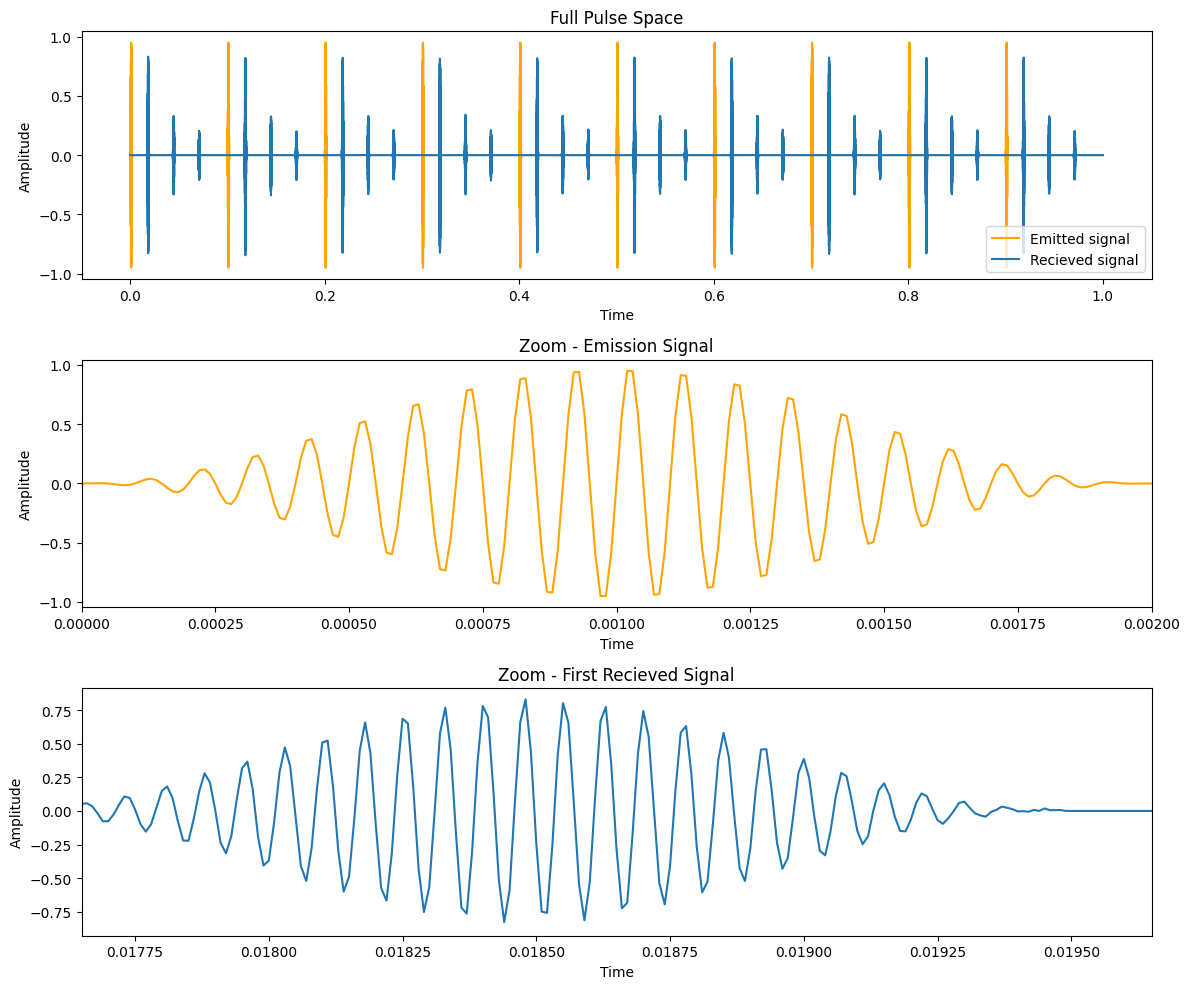

In [74]:
# """ Visualising full pulse space """

fig, ax = plt.subplots(3, 1, figsize = (12, 10))

# Full pulse image
ax[0].plot(t_total, emission_signal, label="Emitted signal", color='orange')
ax[0].plot(t_total, recieved_signal, label="Recieved signal")
ax[0].set_title("Full Pulse Space")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")
ax[0].legend()

# Zooming in on emitted signal
ax[1].plot(t_total, emission_signal, label="Emitted signal", color='orange')
ax[1].set_title("Zoom - Emission Signal")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlim(0, 0.002)

# Zooming in on first recieved signal
threshold = 0.02  # adjust if needed
start_index = np.argmax(recieved_signal > threshold)
end_index = start_index + len(t_pulse)
start_time = t_total[start_index]
end_time = t_total[end_index]

ax[2].plot(t_total, recieved_signal, label="Recieved signal")
ax[2].set_title("Zoom - First Recieved Signal")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Amplitude")
ax[2].set_xlim(start_time, end_time)

plt.tight_layout()
plt.savefig("figures/pulse-spectrum-visualisation", dpi=300)
plt.show()

In [15]:
""" Windowing received signal and applying FFT """
chunk_size = 1024
hop_size = chunk_size // 2
windows = []

for start in range(0, len(recieved_signal) - chunk_size + 1, hop_size):
    window = recieved_signal[start: start+chunk_size] * np.hanning(chunk_size)
    windows.append(window)

magnitudes = []
for window in windows:
    result = np.fft.rfft(window)
    magnitudes.append(np.abs(result)) # abs discards phase

freqs = np.fft.rfftfreq(chunk_size, 1 / sample_rate)
magnitudes = np.array(magnitudes)

In [16]:
""" Collecting dominant frequencies and interpolating """
dominant_freqs = []
for mags in magnitudes:

    peaks, _ = find_peaks(mags, height=0.9*np.max(mags), prominence=2)
    for peak in peaks:

        if peak == 0 or peak == len(mags) - 1:
            dominant_freqs.append((freqs[peak], mags[peak]))

        p_0 = np.log(mags[peak - 1])
        p_1 = np.log(mags[peak])
        p_2 = np.log(mags[peak + 1])

        # Finding parabola vertex
        denom = p_0 - 2*p_1 + p_2
        if denom == 0: # Preventing / 0
            p = 0.0
        else:
            p = 0.5 * (p_0 - p_2)/denom

        freq_interp = freqs[peak] + p * (freqs[1] - freqs[0])
        log_mag_interp = p_1 - 0.25 * (p_0 - p_2) * p
        mag_interp = np.exp(log_mag_interp)
        
        dominant_freqs.append((freq_interp, mag_interp))

In [17]:
""" Making sure we aren't detecting the same peak twice in a row """
filtered_freqs = []
tolerance = 500
i = 0
while i < len(dominant_freqs) - 1:
    f1, m1 = dominant_freqs[i]
    f2, m2 = dominant_freqs[i + 1]

    if np.abs(f1 - f2) < 500:
        if m1 >= m2:
            filtered_freqs.append((f1, m1))
        else:
            filtered_freqs.append((f2, m2))
        i += 2

    else:
        filtered_freqs.append((f1, m1))
        i += 1

# Handling last one 
if i == len(dominant_freqs) - 1:
    filtered_freqs.append(dominant_freqs[i])

In [18]:
""" Sorting dominant freqs into respective targets """
target_tracks = [[] for _ in range(len(targets))]
for i in range(len(targets)):
    target_tracks[i] = filtered_freqs[i::3]

In [19]:
""" Converting frequency to velocity data """
vel_target_tracks = [[] for _ in range(len(target_tracks))]
for i in range(len(target_tracks)):
    for freq, _ in target_tracks[i]:
        ratio = freq/f_emission
        doppler_vel = V_SOUND * (ratio - 1)/(ratio + 1)
        vel_target_tracks[i].append(doppler_vel)

In [55]:
""" Applying Kalman filter to velocity tracks """
# Initial Kalman state: [v]
v_est = np.array([[vel_target_tracks[0][0]]])

F = np.array([[1]])
H = np.array([[1]])
P = np.eye(1) * 250
Q = np.eye(1) * 0.2
R = np.eye(1) * 4
I = np.eye(1)

filtered_vel_tracks = []
for track in vel_target_tracks:
    v_est = np.array([[track[0]]])  # Reset for each target
    P_est = P.copy()
    filtered = [v_est.item()]

    for z in track[1:]:
        z = np.array([[z]])

        # Predict
        v_est = F @ v_est
        P = F @ P @ F.T + Q

        # Update
        res = z - H @ v_est
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)

        v_est = v_est + K @ res
        P = (I - K @ H) @ P

        filtered.append(v_est.item())

    filtered_vel_tracks.append(filtered)

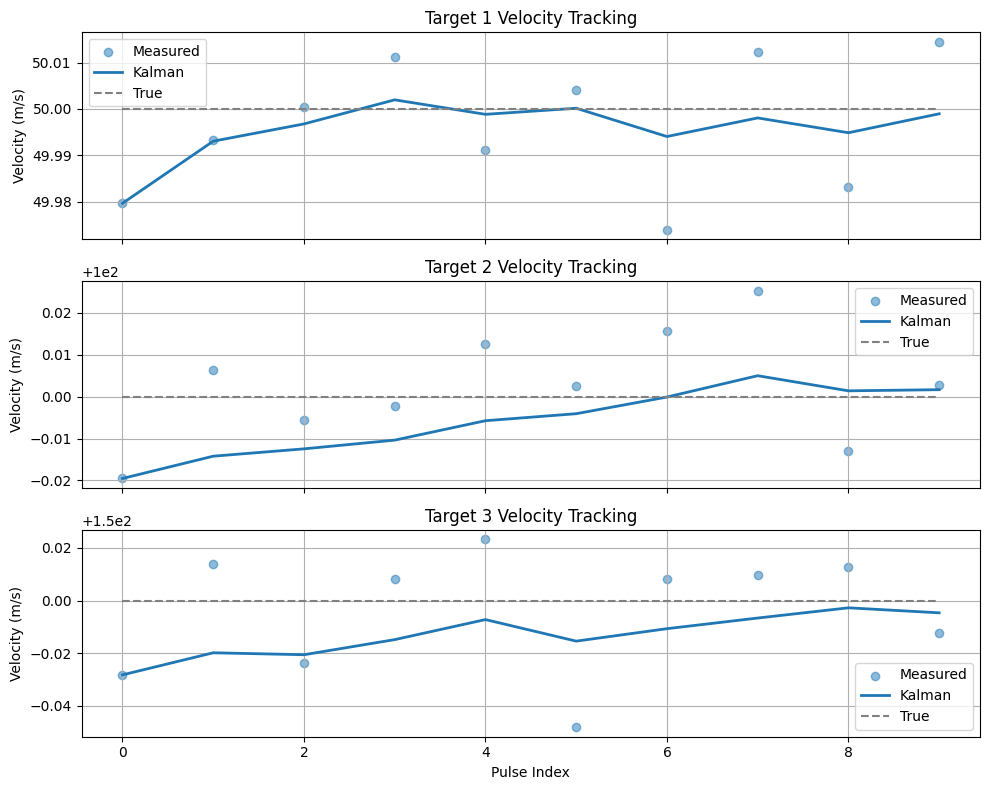

In [71]:
""" Plotting measurment accuracy and spread for each target """

true_vels = [t['vel'] for t in targets]
num_pulses = len(vel_target_tracks[0])
t_vals = np.arange(num_pulses)

fig, axes = plt.subplots(len(targets), 1, figsize=(10, 8), sharex=True)

for i, ax in enumerate(axes):
    # Plot measured velocity
    ax.scatter(t_vals, vel_target_tracks[i], alpha=0.5, label="Measured", marker='o')

    # Plot Kalman-filtered velocity
    ax.plot(t_vals, filtered_vel_tracks[i], label="Kalman", linewidth=2)

    # Plot true velocity
    ax.plot(t_vals, [true_vels[i]] * num_pulses, label="True", linestyle='--', color='gray')

    ax.set_ylabel("Velocity (m/s)")
    ax.set_title(f"Target {i+1} Velocity Tracking")
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel("Pulse Index")
plt.tight_layout()
plt.savefig("figures/target-tracking-comparisons.png", dpi=300)
plt.show()


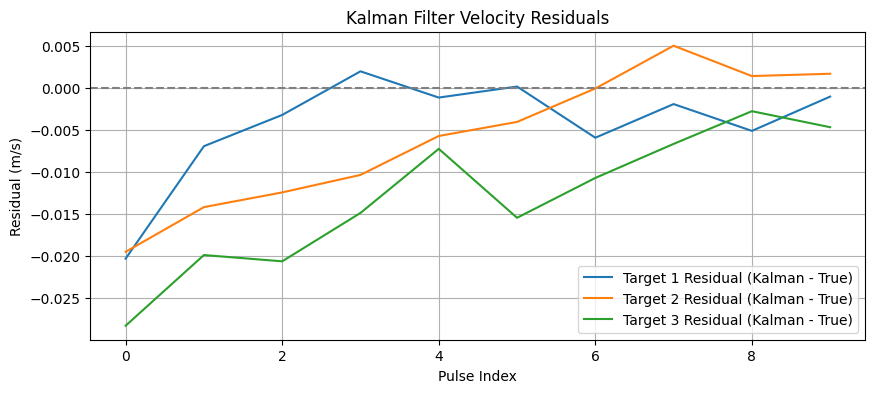

In [72]:
""" Plotting Kalman filter residuals """
plt.figure(figsize=(10, 4))
for i in range(len(targets)):
    residuals = np.array(filtered_vel_tracks[i]) - np.array(true_vels[i])
    plt.plot(residuals, label=f"Target {i+1} Residual (Kalman - True)")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Kalman Filter Velocity Residuals")
plt.xlabel("Pulse Index")
plt.ylabel("Residual (m/s)")
plt.legend()
plt.grid(True)
plt.savefig("figures/kalman-velocity-residual-tracking.png", dpi=300)
plt.show()

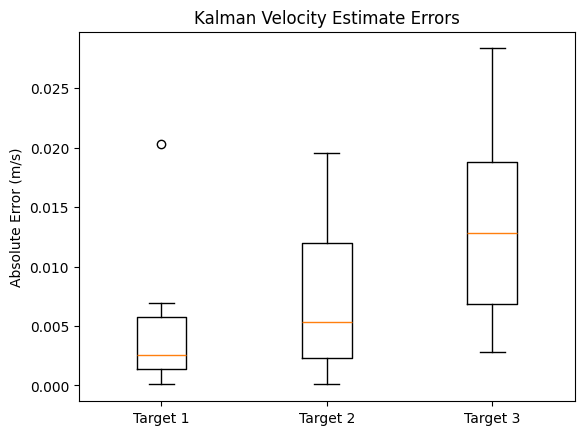

In [73]:
errors = []
for i in range(len(targets)):
    kalman_error = np.abs(np.array(filtered_vel_tracks[i]) - np.array(true_vels[i]))
    errors.append(kalman_error)

plt.boxplot(errors, tick_labels=[f"Target {i+1}" for i in range(len(targets))])
plt.title("Kalman Velocity Estimate Errors")
plt.ylabel("Absolute Error (m/s)")
plt.savefig("figures/kalman-velocity-error-estimates.png", dpi=300)
plt.show()